In [ ]:
"""Registration procedure for model order reduction of advection dominated flows with pointwise neural networks""""

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from torch.func import vmap, jacrev  # Ensure functorch is available
import pdb
import torch.nn.functional as F
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from torch.autograd.functional import jacobian

In [ ]:
def interp(x: torch.Tensor, xp: torch.Tensor, fp: torch.Tensor, dim: int=-1, extrapolate: str='constant') -> torch.Tensor:
    """One-dimensional linear interpolation between monotonically increasing sample
    points, with extrapolation beyond sample points.

    Returns the one-dimensional piecewise linear interpolant to a function with
    given discrete data points :math:`(xp, fp)`, evaluated at :math:`x`.

    Args:
        x: The :math:`x`-coordinates at which to evaluate the interpolated
            values.
        xp: The :math:`x`-coordinates of the data points, must be increasing.
        fp: The :math:`y`-coordinates of the data points, same shape as `xp`.
        dim: Dimension across which to interpolate.
        extrapolate: How to handle values outside the range of `xp`. Options are:
            - 'linear': Extrapolate linearly beyond range of xp values.
            - 'constant': Use the boundary value of `fp` for `x` values outside `xp`.

    Returns:
        The interpolated values, same size as `x`.
    """
    # Move the interpolation dimension to the last axis
    x = x.movedim(dim, -1)
    xp = xp.movedim(dim, -1)
    fp = fp.movedim(dim, -1)

    m = torch.diff(fp) / torch.diff(xp) # slope
    b = fp[..., :-1] - m * xp[..., :-1] # offset

    indices = torch.searchsorted(xp, x, right=False)

    if extrapolate == 'constant':
        # Pad m and b to get constant values outside of xp range
        m = torch.cat([torch.zeros_like(m)[..., :1], m, torch.zeros_like(m)[..., :1]], dim=-1)
        b = torch.cat([fp[..., :1], b, fp[..., -1:]], dim=-1)
    else: # extrapolate == 'linear'
        indices = torch.clamp(indices - 1, 0, m.shape[-1] - 1)

    values = m.gather(-1, indices) * x + b.gather(-1, indices)

    return values.movedim(-1, dim)

In [ ]:
# Detect if CUDA is available; else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class Network(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=3, activation_fn=nn.ReLU()):
        """
        Branch Network encodes the input function into a feature vector.

        Args:
            input_dim (int): Dimension of the branch input.
            hidden_dim (int): Hidden layer size.
            output_dim (int): Output dimension.
            num_layers (int): Number of layers in the network.
            activation_fn (nn.Module): Activation function to use.
        """
        super(Network, self).__init__()
        layers = []

        # First layer
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(activation_fn)

        # Hidden layers
        for _ in range(num_layers - 2):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(activation_fn)

        # Output layer
        layers.append(nn.Linear(hidden_dim, output_dim))

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)*x[...,1:]*(1-x[...,1:])

# Function to count parameters
def count_parameters(model):
    """
    Counts and prints the number of trainable parameters in the model.

    Args:
        model (torch.nn.Module): The PyTorch model.

    Returns:
        int: Total number of trainable parameters.
    """
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters: {total_params}")
    print("\nBreakdown by submodules:")
    for name, module in model.named_children():
        module_params = sum(p.numel() for p in module.parameters() if p.requires_grad)
        print(f"  {name}: {module_params} parameters")
    return total_params


Using device: cuda


In [ ]:
# Define the cutoff Gaussian function θ
def theta(x, a, b, c, cutoff_sharpness=50):
    """
    Computes the cutoff Gaussian function θ(x; a, b, c) with a smooth cutoff.

    Args:
        x (torch.Tensor): The input tensor (domain variable x), shape [num_x].
        a (float or torch.Tensor): The amplitude of the Gaussian.
        b (float or torch.Tensor): The width parameter of the Gaussian.
        c (float or torch.Tensor): The cutoff center of the Gaussian.
        cutoff_sharpness (float): Controls the smoothness of the cutoff. Larger values make it steeper.

    Returns:
        torch.Tensor: The values of θ(x; a, b, c), shape [num_x].
    """
    gaussian = a * torch.exp(-((x - c) / b) ** 2)  # Gaussian term
    smooth_cutoff = torch.sigmoid(-cutoff_sharpness * (x - c))  # Smooth cutoff using sigmoid
    #sharp_cutoff = torch.where(x < c, gaussian, torch.zeros_like(x))  # Apply the cutoff condition
    return gaussian * smooth_cutoff  # Apply smooth cutoff


# Define the piecewise Gaussian function γ(x, μ)
def gamma(x, mu,cutoff_sharpness=50):
    """
    Computes the piecewise Gaussian function γ(x, μ).

    Args:
        x (torch.Tensor): The input tensor (domain variable x), shape [num_x].
        mu (torch.Tensor): The parameter tensor μ, shape [num_mu].

    Returns:
        torch.Tensor: The values of γ(x, μ), shape [num_mu, num_x].
    """
    # Parameters a, b, and c for both Gaussian terms
    a1, b1, c1 = 0.2*(mu**(-1/2)), 0.1, mu
    a2, b2, c2 = 0.2*(mu**(-1/2)), 0.004 * mu**(-2), -mu
    # Compute the first and second Gaussian terms
    term1 = theta(x, a1, b1, c1,cutoff_sharpness)  # Shape [num_mu, num_x]
    term2 = theta(x, a2, b2, c2,cutoff_sharpness)  # Shape [num_mu, num_x]

    return term1 + term2

# Define the domain mapping function L_τ(x)
def L_tau(x, tau):
    """
    Computes the domain mapping function L_τ(x).

    Args:
        x (torch.Tensor): The input tensor (domain variable x), shape [num_x].
        tau (torch.Tensor): The mapping parameter τ, shape [num_tau].

    Returns:
        torch.Tensor: The values of L_τ(x), shape [num_tau, num_x].
    """
    return x + 4 * (tau - 0.5) * x * (1 - x)

# Define the mapped Gaussian function Γ_τ(x, μ)
def gamma_tau(x, mu, tau,cutoff_sharpness=50):
    """
    Computes the mapped Gaussian function Γ_τ(x, μ).

    Args:
        x (torch.Tensor): The input tensor (domain variable x), shape [num_x].
        mu (torch.Tensor): The parameter tensor μ, shape [num_mu].
        tau (torch.Tensor): The mapping parameter τ, shape [num_tau].

    Returns:
        torch.Tensor: The values of Γ_τ(x, μ), shape [num_tau, num_mu, num_x].
    """
    # Compute the mapped domain L_τ(x)
    L_x = L_tau(x, tau)  # Shape [num_tau, num_x]

    # Compute the Gaussian function γ(L_τ(x), μ)
    gamma_values = gamma(L_x, mu,cutoff_sharpness)  # Shape [num_tau, num_mu, num_x]

    return gamma_values

In [ ]:
# Hyperparameters
input_dim =2
hidden_dim =40
epochs = 2000               # Number of training epochs
batch_size = 5            # Batch size for training
penalty_lambda = 2e-3        # Weight for the penalty term in loss function
output_dim = 1              # Output dimension for final prediction
num_layers=4
learning_rate = 4e-3

# Instantiate Activation Functions (can be changed as needed)
activation = nn.GELU()

num_x = 600  # Number of points in x
num_train = 40
cutoff_sharpness = 100

x = torch.linspace(0, 1, num_x).reshape(1,-1)  # x ranging between 0 and 1, shape [num_x]
mu = torch.linspace(0.3, 0.7, num_train).reshape(-1,1)  # μ values, shape [num_mu]
# tau = torch.linspace(0, 1, num_tau)  # τ values, shape [num_tau]

# Compute γ(x, μ) for all combinations of x and μ
gamma_values = gamma(x, mu,cutoff_sharpness)  # Shape [num_mu, num_x]

# Compute Γ_τ(x, μ) for all combinations of x, μ, and τ
gamma_tau_values = gamma_tau(x, mu, mu,cutoff_sharpness)  # Shape [num_tau, num_mu, num_x]

L_x = L_tau(x, mu)

In [ ]:
# Prepare Training Data
torch.manual_seed(42)
# data = generate_data(num_train, trunk_input_dim)
model = Network(input_dim, hidden_dim, output_dim, num_layers=num_layers, activation_fn=activation).to(device)
# model = Siren(input_dim, hidden_dim, num_layers, output_dim, outermost_linear=True, hidden_omega_0=30).to(device)
count_parameters(model)

# Convert data to tensors and move to device
branch_inputs = mu.reshape(-1,1,1).repeat(1,num_x,1).to(device)
trunk_inputs = x.reshape(1,-1,1).repeat(num_train,1,1).to(device)
inputs = torch.cat((branch_inputs, trunk_inputs), dim=-1)
targets = torch.cat((gamma_values.unsqueeze(-1).to(device),gamma_values[19:20,:].unsqueeze(-1).repeat(num_train,1,1).to(device)),dim=-1)

Total trainable parameters: 3441

Breakdown by submodules:
  net: 3441 parameters


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs,eta_min=1e-8)
criterion = nn.MSELoss()
dataloader = DataLoader(TensorDataset(inputs, targets), batch_size=batch_size, shuffle=True)

for epoch in range(1, epochs + 1):
    model.train()
    epoch_loss = 0.0
    epoch_mse = 0.0
    epoch_penalty = 0.0
    for batch_input, batch_target in dataloader:
        optimizer.zero_grad()
        # Forward pass
        batch_input.requires_grad_(True)
        output = model(batch_input.to(device))  # [batch, 1], [batch, D], [batch]

        sampling_grid = batch_input[...,1:] + output #deformed mesh
        warped_image = gamma(sampling_grid, batch_input[:,:,:1],cutoff_sharpness)  # [batch, num_mu, num_x]

        g = torch.autograd.grad(output, batch_input, grad_outputs=torch.ones_like(output), create_graph=True)[0]
        # second_grad = torch.autograd.grad(g, batch_input,grad_outputs=torch.ones_like(g), retain_graph=True)[0][:,:,1:]
        # Compute MSE Loss
        mse_loss = criterion(warped_image, batch_target[:,:,1:].to(device))  # [batch, 1] vs [batch, 1]
        # Compute Penalty: softplus(-det(Jacobian)) = softplus(-det_J)
        #penalty = torch.mean(torch.nn.functional.softplus(-det_J))
        penalty = torch.mean(torch.square(g[:,:,1:]))
        # Total Loss
        loss = mse_loss + penalty_lambda * penalty
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        # Accumulate loss
        epoch_loss += loss.item()
        epoch_mse += mse_loss.item()
        epoch_penalty += penalty.item()
    scheduler.step()
    # Calculate average loss
    avg_loss = epoch_loss / len(dataloader)
    pen_loss = epoch_penalty / len(dataloader)
    mse_loss_avg = epoch_mse / len(dataloader)
    # avg_penalty = epoch_penalty / num_train
    if epoch % 100 == 0 or epoch == 1:
        print(f"Epoch [{epoch}/{epochs}], Loss: {avg_loss:.4e}, Penalty: {pen_loss:.4e}, MSE: {mse_loss_avg:.4e}")

Epoch [1/2000], Loss: 5.7503e-03, Penalty: 1.3296e-03, MSE: 5.7476e-03
Epoch [100/2000], Loss: 2.0931e-04, Penalty: 7.8277e-02, MSE: 5.2753e-05
Epoch [200/2000], Loss: 2.2086e-04, Penalty: 7.7051e-02, MSE: 6.6762e-05
Epoch [300/2000], Loss: 2.1092e-04, Penalty: 7.2853e-02, MSE: 6.5213e-05
Epoch [400/2000], Loss: 1.8984e-04, Penalty: 6.9398e-02, MSE: 5.1048e-05
Epoch [500/2000], Loss: 1.8561e-04, Penalty: 6.8849e-02, MSE: 4.7907e-05
Epoch [600/2000], Loss: 1.8449e-04, Penalty: 6.8709e-02, MSE: 4.7071e-05
Epoch [700/2000], Loss: 1.8360e-04, Penalty: 6.8761e-02, MSE: 4.6077e-05
Epoch [800/2000], Loss: 1.8221e-04, Penalty: 6.8652e-02, MSE: 4.4903e-05
Epoch [900/2000], Loss: 1.8204e-04, Penalty: 6.8781e-02, MSE: 4.4477e-05
Epoch [1000/2000], Loss: 1.8166e-04, Penalty: 6.9034e-02, MSE: 4.3595e-05
Epoch [1100/2000], Loss: 1.8286e-04, Penalty: 6.8918e-02, MSE: 4.5024e-05
Epoch [1200/2000], Loss: 1.8072e-04, Penalty: 6.9056e-02, MSE: 4.2610e-05
Epoch [1300/2000], Loss: 1.8052e-04, Penalty: 6.90

In [ ]:
# Testing
model.eval()
model = model.to(device)
with torch.no_grad():
   out = model(inputs) + inputs[...,1:]
   warped_image =  gamma(out, inputs[...,:1],cutoff_sharpness)[...,0]
  #  interp(out.squeeze(-1),inputs[...,-1],targets[...,0].squeeze(-1))

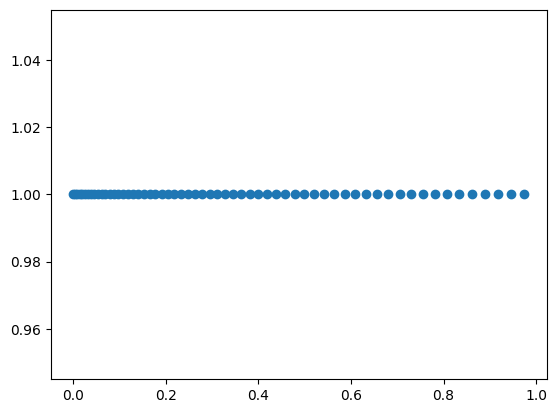

In [ ]:
plt.scatter(L_x[1][::10],torch.ones_like(L_x[1][::10]))

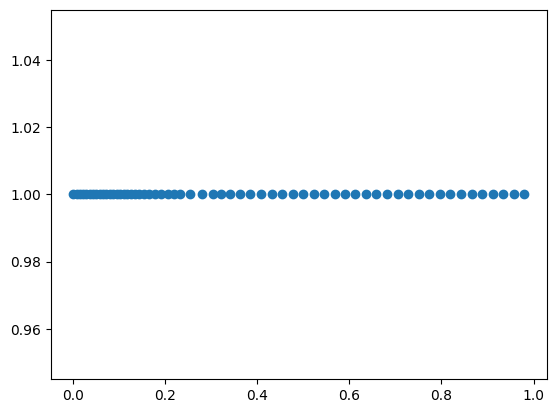

In [ ]:
plt.scatter(out[1,:,0][::10].cpu(),torch.ones_like(out[1,:,0][::10].cpu()))

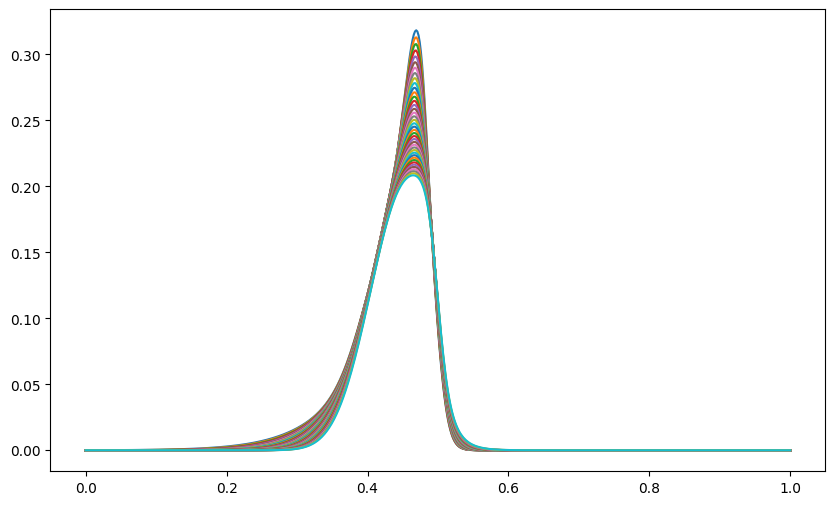

In [ ]:
plt.figure(figsize=(10, 6))
for i in range(40):
    plt.plot(x[0],warped_image[i].cpu())
# plt.plot(x[0],targets[4,:,1].cpu())

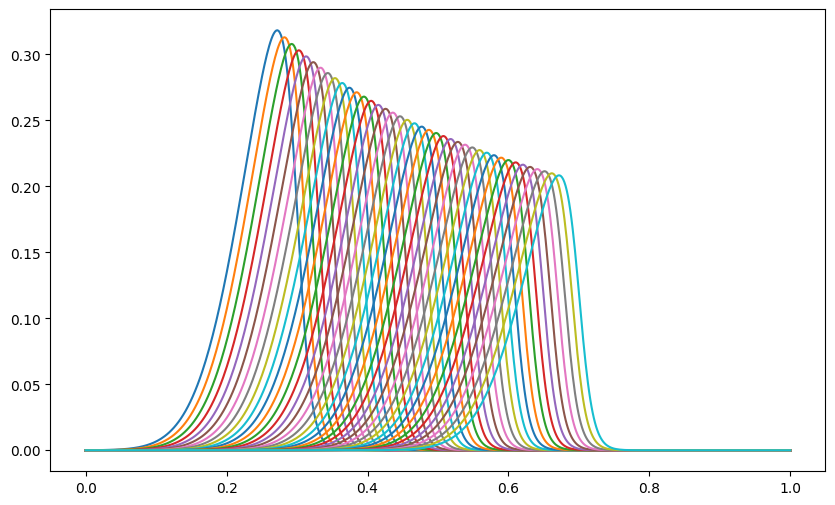

In [ ]:
plt.figure(figsize=(10, 6))
for i in range(40):
    plt.plot(x[0],gamma_values[i])

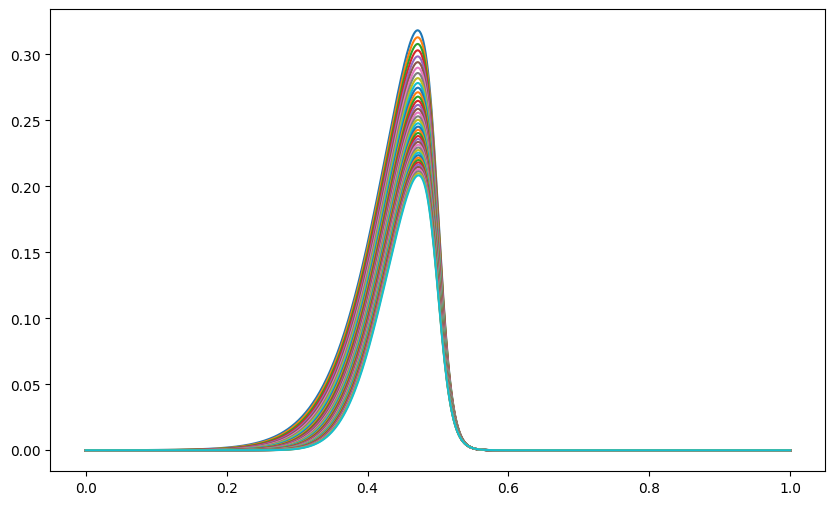

In [ ]:
plt.figure(figsize=(10, 6))
for i in range(40):
    plt.plot(x[0],gamma_tau_values[i])

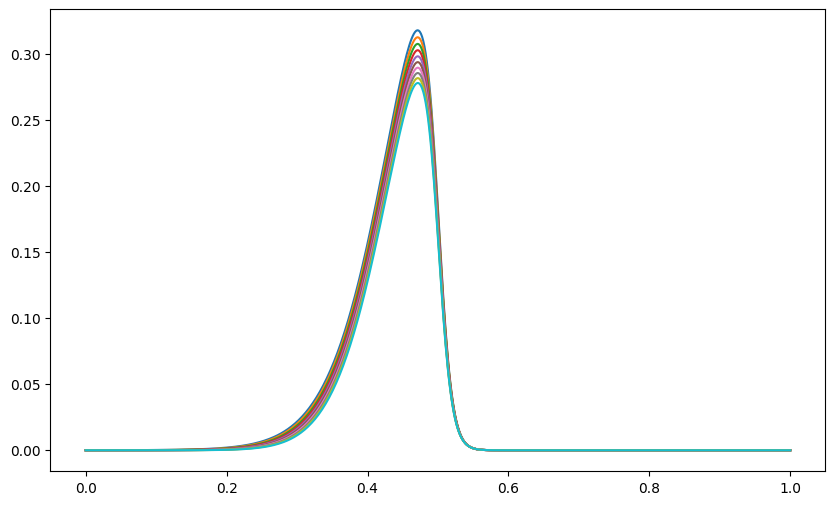

In [ ]:
warped_image_original = interp(L_x,inputs[...,-1].cpu(),targets[...,0].squeeze(-1).cpu())
plt.figure(figsize=(10, 6))
for i in range(10):
    plt.plot(x[0],warped_image_original[i])

In [ ]:
U_ref,S_ref, V_ref = torch.linalg.svd(warped_image)
U_tau,S_tau, V_tau = torch.linalg.svd(gamma_tau_values)
U_original,S_original, V_original = torch.linalg.svd(gamma_values)